### In class activity: eigenvector and random walk centrality

Begin by creating some utilities that will be helpful. We'll use some visualization utilities, some utilities for getting the adjacency matrix for a graph, and so on.


In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from typing import Tuple, Hashable, Union
from numpy import linalg as linalg
from matplotlib.axes import Axes

######################################
## Get adjacency matrix for a graph ##
## with rows in sorted node order   ##
## and matrix as an ND Array        ## 
######################################
def get_adjacency_matrix(G: Union[nx.Graph, nx.DiGraph]) -> NDArray:
    return nx.adjacency_matrix(G,nodelist=[node for node in sorted(G.nodes)]).toarray()  

#################################
## Show graph with node labels ##
## or with centrality labels   ##
#################################
def show_graph(G: nx.Graph,
               title: str = "",
               labels: Union[dict[int, str], None] = None,
               axes: Union[None, Axes] = None
               ) -> dict[Hashable, Tuple[float, float]]:
    if labels is None:
        labels = {node: str(node) for node in G.nodes()}
    node_positions: dict[Hashable, tuple[float,float]] = nx.nx_pydot.graphviz_layout(G,prog='neato')
    if axes is None:
        plt.figure(figsize=(4,4))
        axes: Axes = plt.gca()

    nx.draw(G, 
        node_positions, 
        node_color = ['y' for _ in G.nodes], 
        with_labels = True, 
        labels = labels,
        node_size = 300,
        ax=axes, 
        alpha=0.8)
    
    axes.set_title(title)
    axes.set_aspect('equal')
    x, y = zip(*node_positions.values())
    xmin = float(np.min(x))
    xmax = float(np.max(x))
    ymin = float(np.min(y))
    ymax = float(np.max(y))
    axes.set_xlim(xmin - 0.2*(xmax-xmin), xmax +0.2*(xmax-xmin))
    axes.set_ylim(ymin - 0.2*(ymax-ymin), ymax +0.2*(ymax-ymin))
    
    return node_positions

def show_digraph(G: nx.DiGraph,
                 title: str = "",
                 labels: Union[dict[int, str], None] = None,
                 axes: Union[None, Axes] = None
                 ) -> dict[Hashable, Tuple[float, float]]:
    if labels is None:
        labels = {node: str(node) for node in G.nodes()}
    node_positions: dict[Hashable, tuple[float,float]] = nx.nx_pydot.graphviz_layout(G,prog='neato')
    if axes is None:
        plt.figure(figsize=(4,4))
        axes: Axes = plt.gca()
    nx.draw_networkx_nodes(G, 
        node_positions, 
        node_color = ['y' for _ in G.nodes], 
        node_size = 300, 
        alpha=0.8,
        ax=axes)
    nx.draw_networkx_labels(G, node_positions, labels=labels, ax=axes)
    nx.draw_networkx_edges(
        G,
        node_positions,
        connectionstyle='arc3, rad=0.2',
        arrows=True,
        arrowsize = 20,
        width = 1,
        ax=axes
    )
    axes.set_title(title)
    axes.set_aspect('equal')
    x, y = zip(*node_positions.values())
    xmin = float(np.min(x))
    xmax = float(np.max(x))
    ymin = float(np.min(y))
    ymax = float(np.max(y))
    axes.set_xlim(xmin - 0.2*(xmax-xmin), xmax +0.2*(xmax-xmin))
    axes.set_ylim(ymin - 0.2*(ymax-ymin), ymax +0.2*(ymax-ymin))
    
    return node_positions

#############################
## Utilties for generating ##
## illustrative networks   ##
#############################
def get_pinwheel_graph() -> Tuple[nx.Graph, str]:
    G: nx.Graph = nx.Graph()
    G.add_nodes_from([1,2,3,4,5,6,7,8,9,10])
    G.add_edges_from([(1,2),(2,3),(1,3),(3,7),(7,4),(4,5),(4,6),(5,6),(7,8),(8,9),(8,10),(9,10)])
    title = "Pinwheel graph"
    return G, title
    
def get_barbell_graph() -> Tuple[nx.Graph, str]:
    G: nx.Graph = nx.barbell_graph(3,1)
    title = "Barbell graph"
    return G, title

def get_directed_barbell_graph() -> Tuple[nx.DiGraph, str]:
    G: nx.DiGraph = nx.DiGraph()
    G.add_nodes_from([0,1,2,3,4,5,6])
    G.add_edges_from({(6,5), (6,4),
                      (5,4), (4,3),
                      (3,2),
                      (2,1), (1,0), (0,2)})
    title = "Directed barbell graph"
    return G, title

Let's start with the Barbell graph

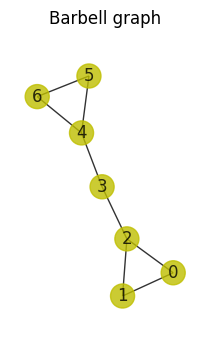

In [27]:
barbell_graph, barbell_title = get_barbell_graph()
_ = show_graph(barbell_graph, barbell_title)

And the directed barbell graph (which we'll use to illustrate some interesting things).

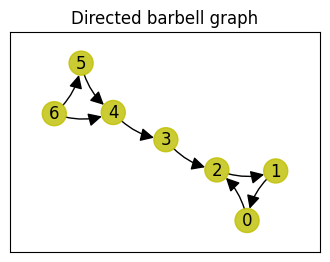

In [28]:
dir_barbell_graph, dir_barbell_title = get_directed_barbell_graph()
_ = show_digraph(dir_barbell_graph, dir_barbell_title)

We'll be finding the principal eigenvector for both directed and undirected graphs. The Perron-Frobenius theorem says that there exists a unique largest eigenvalue (the principal eigenvalue) and corresponding eigenvector (the principal eigenvector) that has all non-negative elements. The following conditions for directed and undirected graphs must be satisfied for the Perron-Frobenius theorem to be satisfied:
- Undirected graph: all elements of the adjacency matrix must be non-negative and there must be at least one edge in the graph
- Directed graph: the graph must be strongly connected

In [29]:
def get_eigenvector_centrality(G: Union[nx.Graph, nx.DiGraph]) -> Tuple[float, NDArray]:
    # Get the adjacency matrix
    A = get_adjacency_matrix(G)

    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A.T) # Don't forget the transpose

    # Find the index of the principal eigenvalue (the largest eigenvalue)
    principal_eigenvalue_index = np.argmax(np.abs(eigenvalues))

    # Get the principal eigenvalue
    principal_eigenvalue = eigenvalues[principal_eigenvalue_index]

    # Get the principal eigenvector
    principal_eigenvector = eigenvectors[:, principal_eigenvalue_index]
    return principal_eigenvalue, principal_eigenvector

def get_randomwalk_centrality(G: Union[nx.Graph, nx.DiGraph]) -> Tuple[float, NDArray]:
    # Get the adjacency matrix
    A = get_adjacency_matrix(G)

    # Turn the matrix into a transition matrix by normalizing
    A_hat: NDArray = A / A.sum(axis=1, keepdims=True)

    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A_hat.T) # Don't forget the transpose

    # Find the index of the principal eigenvalue (the largest eigenvalue)
    principal_eigenvalue_index = np.argmax(np.abs(eigenvalues))

    # Get the principal eigenvalue
    principal_eigenvalue = eigenvalues[principal_eigenvalue_index]

    # Get the principal eigenvector
    principal_eigenvector = eigenvectors[:, principal_eigenvalue_index]
    return principal_eigenvalue, principal_eigenvector

Let's label the graph with the principal eigenvectors, which is the eigenvector centrality

Principal Eigenvalue: 2.34
Principal Eigenvector: [0.33 0.33 0.45 0.38 0.45 0.33 0.33]


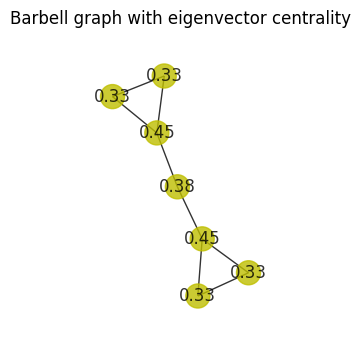

In [30]:
principal_eigenvalue, principal_eigenvector = get_eigenvector_centrality(barbell_graph)

print("Principal Eigenvalue:", np.round(principal_eigenvalue,2))
print("Principal Eigenvector:", np.round(principal_eigenvector,2))

labels: dict[int, str] = {node: np.round(principal_eigenvector[node],2) for \
                          node in sorted(barbell_graph.nodes())}
_ = show_graph(barbell_graph, 
           barbell_title + " with eigenvector centrality", 
           labels = labels)

Repeat with random walk centrality

Random walk principal Eigenvalue: 1.0
Random walk principal Eigenvector: [0.32 0.32 0.49 0.32 0.49 0.32 0.32]


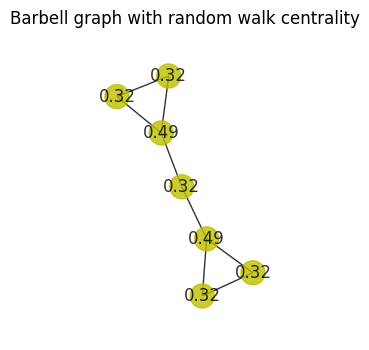

In [31]:
randomwalk_eigenvalue, randomwalk_eigenvector = get_randomwalk_centrality(barbell_graph)

print("Random walk principal Eigenvalue:", np.round(randomwalk_eigenvalue,2))
print("Random walk principal Eigenvector:", np.round(randomwalk_eigenvector,2))

labels: dict[int, str] = {node: np.round(randomwalk_eigenvector[node],2) for \
                          node in sorted(barbell_graph.nodes())}
_ = show_graph(barbell_graph, 
           barbell_title + " with random walk centrality", 
           labels = labels)

Notice how similar the two plots are. Let's plot them side by side for comparison.

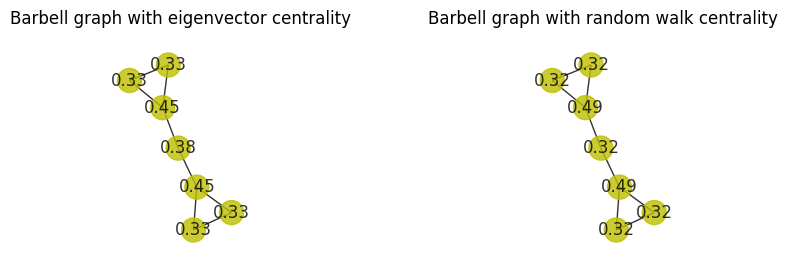

In [32]:
## Set up subplots
_, axes = plt.subplots(1,2, figsize = (10,3))

## Show eigenvector centrality
labels: dict[int, str] = {node: np.round(principal_eigenvector[node],2) for \
                          node in sorted(barbell_graph.nodes())}
_ = show_graph(barbell_graph, 
           barbell_title + " with eigenvector centrality", 
           labels = labels,
           axes=axes[0])

labels: dict[int, str] = {node: np.round(randomwalk_eigenvector[node],2) for \
                          node in sorted(barbell_graph.nodes())}
_ = show_graph(barbell_graph, 
           barbell_title + " with random walk centrality", 
           labels = labels,
           axes=axes[1])

---

Repeat both for the directed barbell graph

Principal Eigenvalue: (-0.5+0.87j)
Principal Eigenvector: [-0.29-0.5j  0.58+0.j  -0.29+0.5j  0.  +0.j   0.  +0.j   0.  +0.j
  0.  +0.j ]


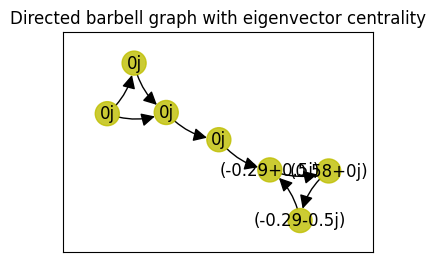

In [33]:
principal_eigenvalue, principal_eigenvector = get_eigenvector_centrality(dir_barbell_graph)

print("Principal Eigenvalue:", np.round(principal_eigenvalue,2))
print("Principal Eigenvector:", np.round(principal_eigenvector,2))

labels: dict[int, str] = {node: np.round(principal_eigenvector[node],2) for \
                          node in sorted(dir_barbell_graph.nodes())}
_ = show_digraph(dir_barbell_graph, 
           dir_barbell_title + " with eigenvector centrality", 
           labels = labels)

Principal Eigenvalue: (-0.5+0.87j)
Principal Eigenvector: [-0.29-0.5j  0.58+0.j  -0.29+0.5j  0.  +0.j   0.  +0.j   0.  +0.j
  0.  +0.j ]


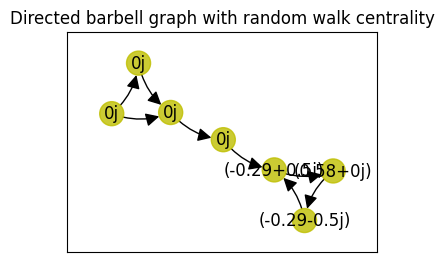

In [34]:
randomwalk_eigenvalue, randomwalk_eigenvector = get_randomwalk_centrality(dir_barbell_graph)

print("Principal Eigenvalue:", np.round(randomwalk_eigenvalue,2))
print("Principal Eigenvector:", np.round(randomwalk_eigenvector,2))

labels: dict[int, str] = {node: np.round(randomwalk_eigenvector[node],2) for \
                          node in sorted(dir_barbell_graph.nodes())}
_ = show_digraph(dir_barbell_graph, 
           dir_barbell_title + " with random walk centrality", 
           labels = labels)

Let's plot them side by side

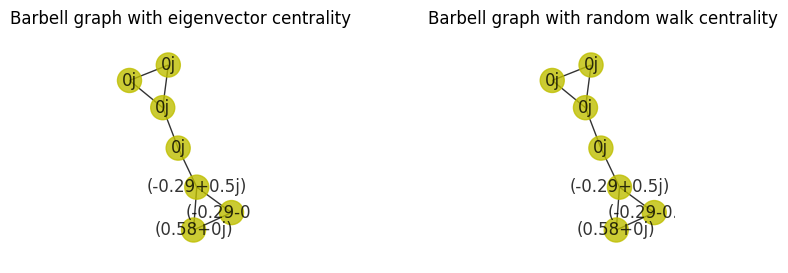

In [35]:
## Set up subplots
_, axes = plt.subplots(1,2, figsize = (10,3))

## Show eigenvector centrality
labels: dict[int, str] = {node: np.round(principal_eigenvector[node],2) for \
                          node in sorted(barbell_graph.nodes())}
_ = show_graph(barbell_graph, 
           barbell_title + " with eigenvector centrality", 
           labels = labels,
           axes=axes[0])

labels: dict[int, str] = {node: np.round(randomwalk_eigenvector[node],2) for \
                          node in sorted(barbell_graph.nodes())}
_ = show_graph(barbell_graph, 
           barbell_title + " with random walk centrality", 
           labels = labels,
           axes=axes[1])

What is going on with the directed barbell graph? Some of the vertices have centrality scores of zero, and some are negative. We can gain some insight by looking at what happens when we animate the diffusion of probability that happens on a random walk on the directed barbell graph.

In [36]:
from IPython import display
import time
import imageio

class Animation_Handler:
    def __init__(self,
                 G: nx.Graph,
                 node_positions: dict[Hashable, Tuple[float, float]]) -> None:
        self.node_positions = node_positions
        self.G = G

    def init_plot(self,
                  probability: np.array) -> None:
        desired_node_size = 200
        plt.figure(figsize=(3,3))
        ax = plt.gca()
        nx.draw(self.G,
                pos = self.node_positions,
                node_size=desired_node_size,
                node_color = probability,
                cmap = 'cool',
                font_color = 'white',
                alpha=0.8,
                with_labels = True)
        ax.set_title("Probability over time")
        sm = plt.cm.ScalarMappable(cmap = 'cool',
                                   norm=plt.Normalize(vmin = 0, vmax=1))
        _ = plt.colorbar(sm, ax=plt.gca())
    
    def update_plot(self,
                    probability: np.array) -> None:
        desired_node_size = 200
        nx.draw_networkx_nodes(self.G,
                pos = self.node_positions,
                node_size=desired_node_size,
                node_color = probability,
                cmap = 'cool',
                vmin=0,
                vmax = 1,
                alpha=0.8)
        nx.draw_networkx_labels(self.G, self.node_positions, font_color='white')
        
        display.display(plt.gcf())
        time.sleep(0.4)
        display.clear_output(wait=True)

Start the random walker at node 6.

In [37]:
p: NDArray = np.zeros([len(dir_barbell_graph.nodes),1])
p[6] = 1 # Put random walker at node 6

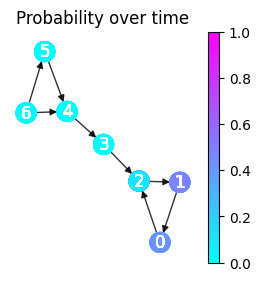

In [38]:
A = get_adjacency_matrix(dir_barbell_graph)

# Turn the matrix into a transition matrix by normalizing
A_hat: NDArray = A / A.sum(axis=1, keepdims=True)

animation: Animation_Handler = Animation_Handler(dir_barbell_graph, 
                                                 nx.nx_pydot.graphviz_layout(dir_barbell_graph,prog='neato'))
t = 0
dt = 1
duration = 20

_ = animation.init_plot(p)

i= 0
while (t<=duration):
    animation.update_plot(p)
    p = A_hat.T@p
    t += dt
    #plt.savefig(f"figures/frame_{i}.png") # Comment out if you don't want to create gif
    i += 1

# Create a GIF.Comment out if you don't want to crate gif
#filenames = [f'figures/frame_{i}.png' for i in range(duration)]
#with imageio.get_writer('probabilty_diffusion.gif', mode='I', duration=0.5, loop = 0) as writer:
#    for filename in filenames:
#        image = imageio.imread(filename)
#        writer.append_data(image)

What you should see is that the random walker starts at node 6 and then randomly splits to go to node 5 and node 4 with equal probability. All other transitions are deterministic, so the probability of the random walker being at a given node gets to nodes 0, 1, and 2, and just cycles around them.

---

### Limitations of Eigenvector Centrality

Let's try to pull the pieces together since that will help us understand the limitations of eigenvector centrality.

**Eigenvector Centrality** 
- Eigenvector centrality is one of the solutions to the eigenvector problem $A^T{\mathbf x} = \lambda {\mathbf x}$
- As discussed in class, the solution that is used is the principal eigenvector because the Perron Frobenius theorem applies if the graph is connected
- Eigenvector centrality uses the adjacency matrix constructed from a vertex's in-degree for directed graphs
- As discussed in class, the Perron Frobenius theorem only applies on directed graphs if the graph is strongly connected

Eigenvector centrality doesn't work on the directed barbell graph because the graph is not connected. The fact that the random walk gets stuck cycling around nodes 0, 1, and 2 helps us understand why there is no eigenvector with all positive values -- things keep changing so no steady state is reached.

---

### Katz Centrality

The formula for Katz Centrality is obtained by solving

$$ {\mathbf x} = \left( I -\alpha A^T\right)^{-1} {\mathbf 1} $$

The idea was to assign each node $\beta = 1$ unit of centrality "for free". If we apply this to the directed barbell graph, we get the following.

In [57]:
def get_spectral_radius(M: NDArray) -> float:
    eigenvalues = np.linalg.eigvals(M)
    return np.max(np.abs(eigenvalues))

def get_katz_centrality(G: Union[nx.Graph, nx.DiGraph]) -> NDArray:
    # Get the adjacency matrix
    A: NDArray = get_adjacency_matrix(G)

    # Set the value of alpha as 1/2 the spectral radius
    alpha: float = 0.5 * get_spectral_radius(A.T)

    # Set up problem
    identity_matrix: NDArray = np.eye(A.T.shape[0])
    ones: NDArray = np.ones((len(A),1))
    
    # Solve
    katz_centrality: NDArray = np.linalg.inv(identity_matrix - alpha*A.T)@ones

    # Normalize so that it is on the same scale as random walk centrality
    katz_centrality = katz_centrality/np.sum(katz_centrality)
    
    return katz_centrality

Let's show what it looks like for the directed barbell graph

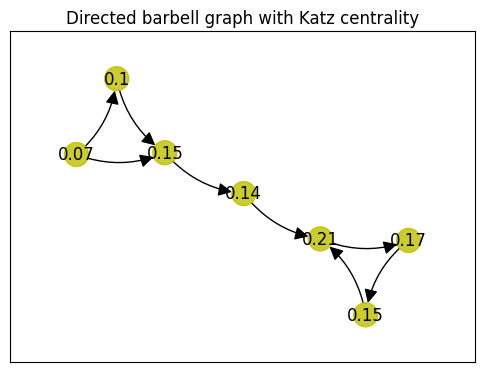

In [58]:
katz_centrality: NDArray = get_katz_centrality(dir_barbell_graph)
labels: dict[int, str] = {node: str(np.round(katz_centrality[node,0],2)) for \
                          node in sorted(dir_barbell_graph.nodes())}

_, ax = plt.subplots(figsize=(6,6))
_ = show_digraph(dir_barbell_graph, 
           dir_barbell_title + " with Katz centrality", 
           labels = labels,
           axes = ax)

---

### Katz Centrality and Random Walks with Teleporting

In a random walk, nodes 0, 1, and 2 form what is sometimes called a "spider trap". Once a random walk agent reaches the spider trap it just cycles around and around and around. We can avoid spider traps by "teleporting" from any node to any other node once in a while. In terms of transition matrices, the ability to teleport from one node to any other node is given by a matrix that has all elements equal to the same value and such that the rows sum to one. For a graph with 7 nodes, like the directed barbell graph above, this is given by

$$ Q = \left[
        \begin{array}{ccccccc}
        1/7   & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  \\
        1/7   & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  \\
        1/7   & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  \\
        1/7   & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  \\
        1/7   & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  \\
        1/7   & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  \\
        1/7   & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  & 1/7  
        \end{array}
    \right]
$$

Let's rewrite the formula for a random walk with teleports. 

$$ {\mathbf p} = \left[\alpha \hat{A}^T + (1-\alpha)Q\right] {\mathbf p} $$

where I've used $\alpha\in[0,1]$ in a new context, which we'll discuss in class. Essentially, it just blends the transition matrix $\hat{A}^T$ with the teleport matrix $Q$. If $\alpha=1$ then we just do a random walk. If $\alpha=0$ then we just teleport.  


The formula for Katz Centrality is analogous to randomly teleporting to a new node. Let's start at node 6 again, but this time we'll add a teleport to the code.

In [62]:
p: NDArray = np.zeros([len(dir_barbell_graph.nodes),1])
p[6] = 1 # Put random walker at node 6

# This is the probability of jumping to any other node
Q: NDArray = np.full((len(p), len(p)), 1/len(p))
print(f"Q = {Q}")
q: NDArray = np.zeros([len(dir_barbell_graph.nodes),1])
for i in range(len(q)):
    q[i] = 1/len(q)
print(q)


Q = [[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]]
[[0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]]


[[0.2787556 ]
 [0.29364427]
 [0.30353584]
 [0.04970714]
 [0.03935714]
 [0.02071429]
 [0.01428571]]


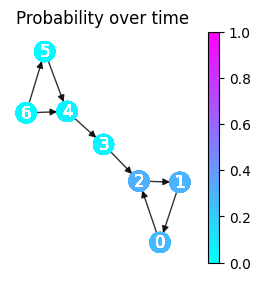

In [63]:
A = get_adjacency_matrix(dir_barbell_graph)

# Turn the matrix into a transition matrix by normalizing
A_hat: NDArray = A / A.sum(axis=1, keepdims=True)

animation: Animation_Handler = Animation_Handler(dir_barbell_graph, 
                                                 nx.nx_pydot.graphviz_layout(dir_barbell_graph,prog='neato'))
t = 0
dt = 1
duration = 40

_ = animation.init_plot(p)

i= 0
alpha = 0.9 # Probability from the transition versus from the teleport
while (t<=duration):
    animation.update_plot(p)
    p = (alpha*A_hat.T + (1-alpha)*Q)@p 
    t += dt
    # plt.savefig(f"figures/frame_{i}.png") # Comment out if you don't want to create gif
    i += 1

print(p)

# Create a GIF.Comment out if you don't want to crate gif
#filenames = [f'figures/frame_{i}.png' for i in range(duration)]
#with imageio.get_writer('probabilty_diffusion.gif', mode='I', duration=0.5, loop = 0) as writer:
#    for filename in filenames:
#        image = imageio.imread(filename)
#        writer.append_data(image)

Let's show Katz centrality and the probability with teleports side-by-side

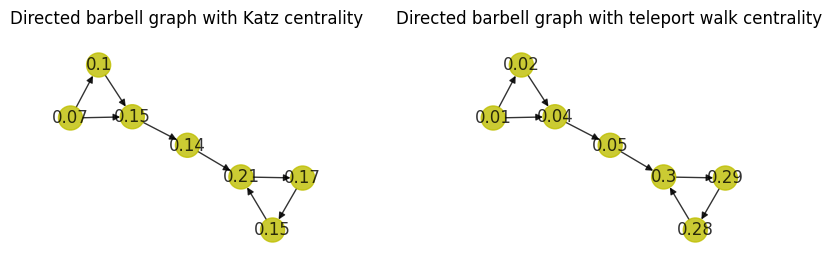

In [66]:
## Set up subplots
_, axes = plt.subplots(1,2, figsize = (10,3))

## Show Katz centrality
labels: dict[int, str] = {node: str(np.round(katz_centrality[node,0],2)) for \
                          node in sorted(dir_barbell_graph.nodes())}
_ = show_graph(dir_barbell_graph, 
           dir_barbell_title + " with Katz centrality", 
           labels = labels,
           axes=axes[0])

# Show new random walk centrality
labels: dict[int, str] = {node: np.round(p[node,0],2) for \
                          node in sorted(barbell_graph.nodes())}
_ = show_graph(dir_barbell_graph, 
           dir_barbell_title + " with teleport walk centrality", 
           labels = labels,
           axes=axes[1])



show problem with eigenvector centrality for source-only nodes, connect to strongly connected criteria for Perron Froben? theorem, explore same problem for random walk centrality